# We provide an unprecedented temporal account of pregnancy and postpartum period based on millions of lab tests

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import matplotlib.cbook
import matplotlib as mpl
import matplotlib.image as mpimg
import time
import itertools
import seaborn as sns
import os
import json
from sympy import *
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.fftpack import rfft,fft,fftfreq,rfftfreq
from scipy.signal import medfilt, find_peaks
from scipy.io import loadmat
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit,brute,basinhopping
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import math
from itertools import combinations
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from string import ascii_uppercase as abc; abc = abc
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from itertools import compress, product
import random
from scipy.interpolate import InterpolatedUnivariateSpline as spline_interp
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patheffects as PathEffects
matplotlib_axes_logger.setLevel('ERROR')
np.seterr(divide='ignore', invalid='ignore')

def_color  = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

init_printing()
plt.rc('font', size=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=8) 
matplotlib.rcParams["figure.dpi"] = 100

# General functions

In [2]:
def remove_top_right_frame(axes):
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

def remove_axe_labels(ax):
    ax.set_title('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
        
def to_dict(keys,values):
    return dict(zip(keys,values))

def get_test_dataframe(path,file):
    tdf       = pd.read_csv(path+file)
    tdf.index = np.array([np.array(s.replace('[','').replace(')','').split(',')).astype(int).mean() for s in tdf['week']])
    tdf       = tdf.drop(columns=['week'])
    tdf.rename(columns={"age50": "age"},inplace=True)
    if len(tdf)<140:
        missing_index = np.sort(list(set(np.arange(-59.5,80.5,1)) - set(tdf.index)))
        tdf = tdf.T
        [tdf.insert(int(np.argwhere(np.arange(-59.5,80.5,1) == missing_index[i])[0][0]),missing_index[i],np.nan) for i in range(len(missing_index))]
        tdf = tdf.T
    return tdf

# Loading the dataset

In [3]:
# Loading the dataset into 'dfs'
path          = '../Clalit Data/pregnancy.1w/'
files    = [file for file in os.listdir(path)]
all_tests= [file.split('.')[0] for file in files]
dfs      = dict(zip(all_tests,[get_test_dataframe(path,file) for file in files]))

# We removed duplicate tests
# Duplicate tests include K:POTASSIUM_BLOOD, Na:SODIUM_BLOOD, RDW:RDW_CV
remove   = ['POTASSIUM_BLOOD','SODIUM_BLOOD','RDW_CV']
all_tests= np.unique(list(set(all_tests)- set(remove)))

# Metadata infotmation
* 'metadata' - Tests names in various forms, divison to groups and units
* 'labnorm'  - Referenence values for tests

In [4]:
'''
Code to create dataframe of tests values by percentile from LabNorm package in R (https://github.com/tanaylab/labNorm)

library(labNorm)
df1 = data.frame()
df2 = data.frame()

for (idx in 1:93) {
  dat1<-ln_quantile_value(c(0,0.01,0.03,0.10,0.15,0.25,0.35,0.50,0.65,0.75,0.85,0.90,0.97,0.99,1), seq(20, 40, by = 1), "female", LAB_DETAILS$short_name[idx])
  df1 <- rbind(df, dat1)
  }

write.csv(df1,file='D:/Alon/AlonProjects/pregnancy/LabNorm.csv', row.names=FALSE)
'''
groups        = ['Liver','Renal','Musculoskeletal','Metabolism','RBCs','Coagulation','Immune','Endocrine']
subgroups_main= ['Liver','Renal I','Renal II','Musculoskeletal','Metabolism','RBCs I','RBCs II','Coagulation','Immune I','Immune II','Endocrine']
subgroups_si  = ['Liver','Renal I','Renal II','Musculoskeletal','Metabolism','RBCs I','RBCs II','RBCs III','Coagulation','Immune I','Immune II','Immune III','Endocrine I','Endocrine II','Endocrine III']
metadata      = pd.read_excel('../Files/Metadata.xlsx',index_col=0).drop(remove)
labnorm       = pd.read_csv('../Files/LabNorm.csv')

## SI figure - test quantile values for females age 30
#### Some tests quantiles are bugged - LUC%,micro/hyper,phu, micro/creat
I replace bugged negative values for some qunatile with the lowest observed quantile value 

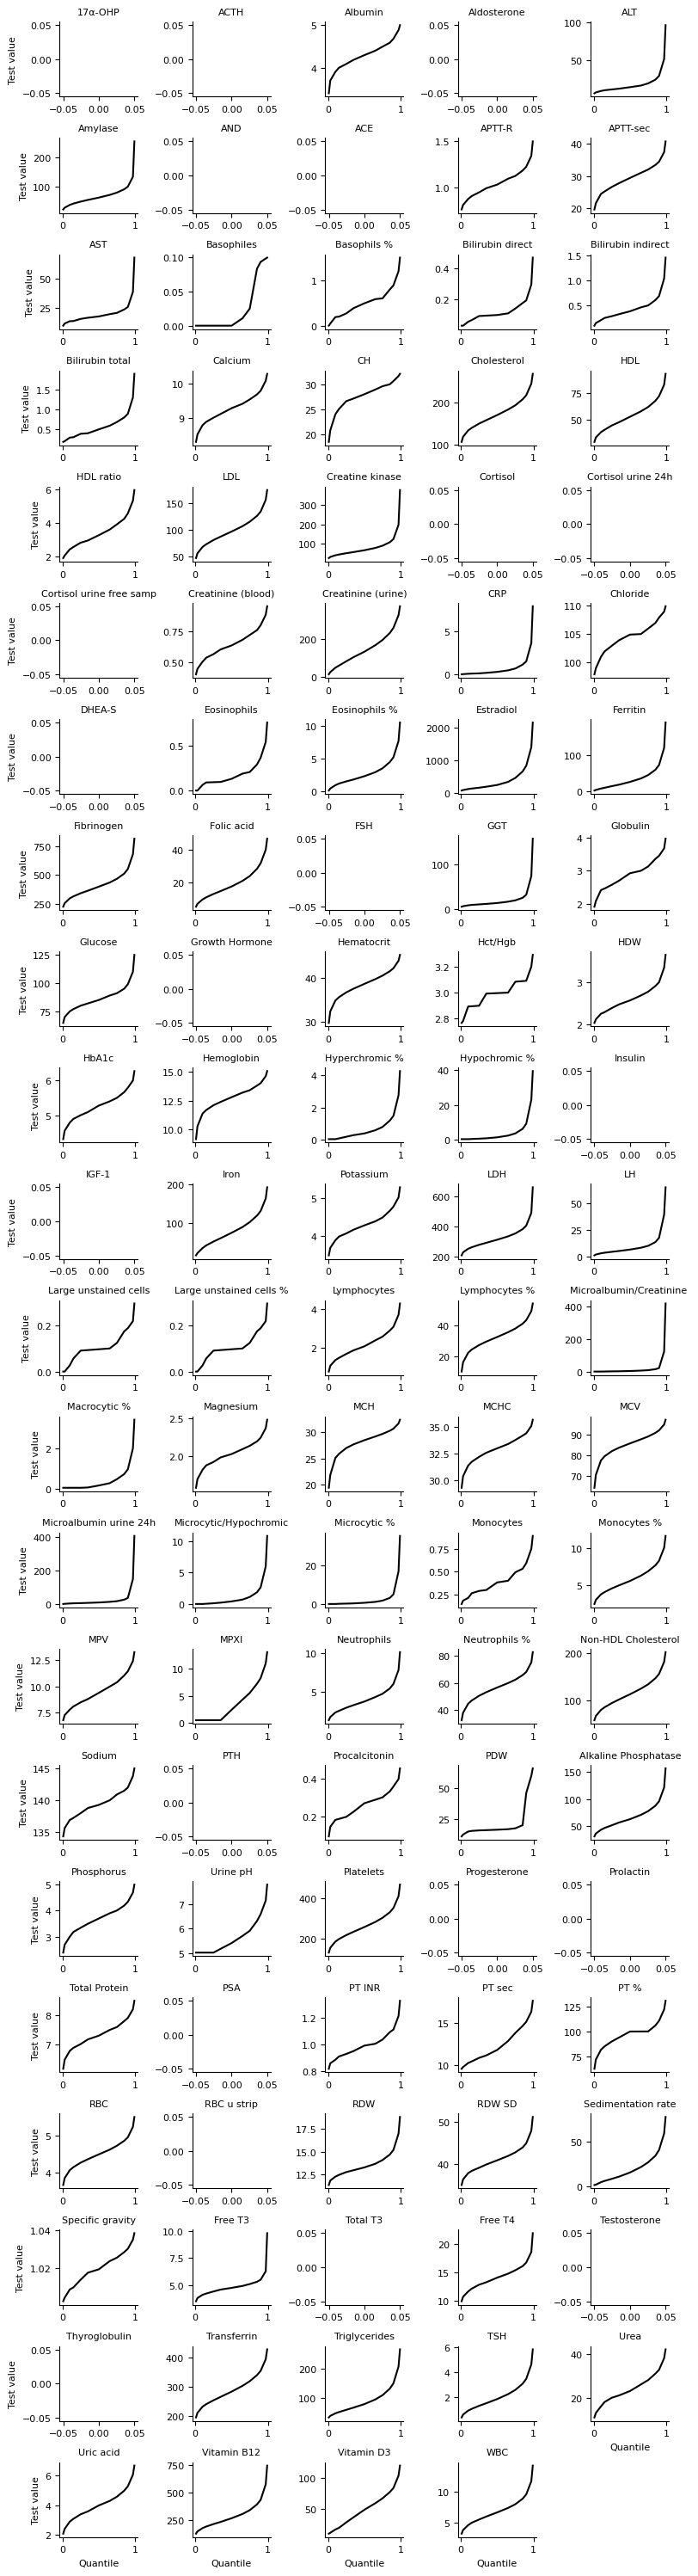

In [5]:
def plot_normlab(tests,age=30):
    nrow = 5
    plt.figure(figsize=(8,30))
    for i,test in enumerate(tests):
        ax  = plt.subplot(int(np.ceil(len(tests)/nrow)),nrow,i+1)
        tdf = labnorm.loc[(labnorm.age==30)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].copy()
        tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
        ax.plot(tdf['quantile'],tdf['value'],c='k')
        ax.set_xlabel('Quantile')
        ax.set_ylabel('Test value')
        ax.set_title(metadata.loc[test]['Nice name'])
        remove_top_right_frame([ax])
        if i<len(tests)-nrow:
            ax.set_xlabel('')
        if np.mod(i,nrow) != 0:
            ax.set_ylabel('')
    plt.tight_layout(); 
    
plot_normlab(all_tests) 
plt.savefig('normlab_q_to_val.pdf',bbox_inches = 'tight',dpi=300)
plt.show()

# We consider only tests with reference values
# We remove possibly biased tests
# This results in 78 tests within the analysis

In [6]:
ndf           = pd.DataFrame([dfs[test]['n'] for test in all_tests],index=all_tests).fillna(0).astype(int)
labnorm_tests = list(metadata.loc[~metadata['LabNorm name'].isna()].index)
bias_df       = pd.read_csv('../Files/bias_score_070523.csv',index_col=0)
bias_tests    = set(bias_df.loc[bias_df.sum(axis=1)<3].index)
removed_tests = set(list(set(all_tests) - set(labnorm_tests)) + list(bias_tests))
tests         = sorted(list(set(labnorm_tests).intersection(all_tests) - set(removed_tests)))
len(tests)

In [7]:
bias_tests

{'AMYLASE_BLOOD',
 'CHOLESTEROL_HDL_RATIO',
 'CREATININE_URINE_SAMPLE',
 'ESTRADIOL_E_2',
 'HCT_HGB_RATIO',
 'LH_LUTEINIZING_HORMONE',
 'M',
 'MICROALBU_U_SAMP',
 'PSA_PROSTATIC_SPECIFIC_ANTIGEN',
 'SEDIMENTATION_RATE',
 'VITAMIN_D3_25_0H_RIA'}

# Fig 1 MAIN - dataset overview

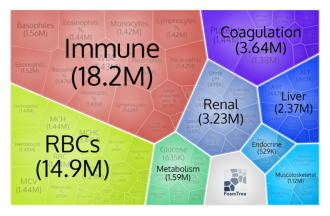

78 in the analysis
Total n for each test: min, max, all tests
36738 1557246 45508593


In [8]:
'''
Fig 1 - dataset overview
'''

def fmt_num(num):
    s = int(np.log10(num))    
    u = {1:'',2:'',3:'K',4:'K',5:'K',6:'M',7:'M',8:'M'}
    k = {1:0,2:0,3:1,4:2,5:0,6:1,7:2,8:0}
    if len(str(num))<4:
        return str(num)
    else:
        n = str(np.round(int(str(num)[:4]),-1))[:3] + u[s]
        if k[s]>0:
            n = n[:k[s]] + '.' + n[k[s]:]  
        return n

# ## make json file to use at https://get.carrotsearch.com/foamtree/latest/demos/settings.html ###
ndf           = pd.DataFrame([dfs[test]['n'] for test in tests],index=tests).fillna(0).astype(int)
tdf          = pd.DataFrame(index=tests)
tdf['n']     = ndf.sum(axis=1)
tdf['group'] = metadata['Group']

json_dict = {"groups":[{"label":group + '\n(' + fmt_num(int(tdf.loc[tdf.group == group]['n'].sum()))+')',"weight":tdf.loc[tdf.group == group]['n'].sum()/tdf['n'].sum(),"groups":[{"label":metadata.loc[test]['Nice name'] + '\n('+ fmt_num(int(tdf.loc[tdf.group == group].loc[test]['n']))+')',"weight":tdf.loc[tdf.group == group].loc[test]['n']/tdf.loc[tdf.group == group]['n'].sum()} for test in list(tdf.loc[tdf.group == group].index)]} for group in groups]}      
with open('../Files/groups_labels.json', 'w') as fp:
    json.dump(json_dict, fp)

plt.figure(figsize=(4,3.5))
ax = plt.subplot(111)
ax.imshow(mpimg.imread('voronoli.PNG'))
ax.set_xticks([]);ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

print(str(len(tests)) +' in the analysis')
print('Total n for each test: min, max, all tests')
print(ndf.sum(axis=1).min(),ndf.sum(axis=1).max(),ndf.sum(axis=1).sum())

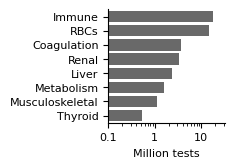

In [9]:
temp          = pd.DataFrame([tdf.loc[tdf['group'] == group]['n'].sum() for group in groups],index=groups,columns=['n'])
temp['group'] = temp.index
temp          = temp.sort_values(by=['n'],ascending=False)
temp['group'].iloc[-1] = 'Thyroid'

plt.figure(figsize=(1.5,1.5))
ax = plt.subplot(111)
sns.barplot(data=temp,y='group',x='n',ax=ax,orient='h',color='dimgray')
ax.set_ylabel('')
ax.set_xscale('log')
ax.set_xlim([10**5,10**7.5])
ax.set_xticklabels(['','0.1','1','10'])
ax.set_xlabel('Million tests')
remove_top_right_frame([ax])
plt.savefig('number_of_tests_group_main.png',bbox_inches = 'tight',dpi=300)
plt.show()

### SI to FIG 1 - Test numbers statistics

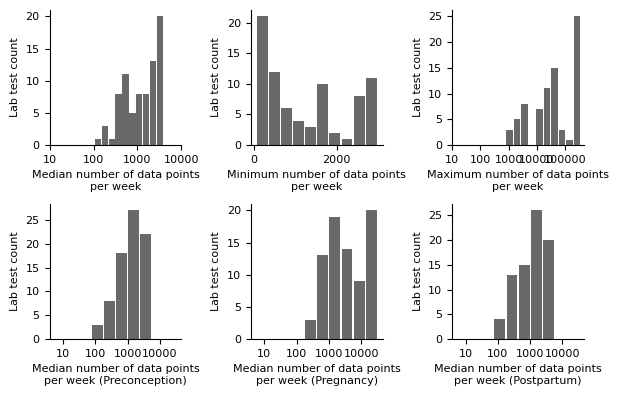

In [10]:
plt.figure(figsize=(6,4))

ax1,ax2,ax3 = plt.subplot(231),plt.subplot(232),plt.subplot(233)
ax1.hist(np.log10(ndf.median(axis=1)),color='dimgray', zorder=2, rwidth=0.9)
ax1.set_xticks(np.arange(1,5,1))
ax1.set_xticklabels([str(int(float(10)**tick)) for tick in ax1.get_xticks()])
ax1.set_ylabel('Lab test count')
ax1.set_xlabel('Median number of data points\nper week')

ax2.hist(ndf.min(axis=1),color='dimgray', zorder=2, rwidth=0.9)
ax2.set_ylabel('Lab test count')
ax2.set_xlabel('Minimum number of data points\nper week')

ax3.hist(np.log10(ndf.max(axis=1)),color='dimgray', zorder=2, rwidth=0.9)
ax3.set_xticks(np.arange(1,6,1))
ax3.set_xticklabels([str(int(float(10)**tick)) for tick in ax3.get_xticks()])
ax3.set_ylabel('Lab test count')
ax3.set_xlabel('Maximum number of data points\nper week')
remove_top_right_frame([ax1,ax2,ax3])

### Median of tests distribution per period
ax = plt.subplot(234)
ax.hist(np.log10(np.median(ndf.T.loc[-60:-38],axis=0)),color='dimgray', zorder=2, rwidth=0.9,range =(0.75,4.5))
ax.set_ylabel('Lab test count')
ax.set_xlabel('Median number of data points\nper week (Preconception)')
ax.set_xticks(np.arange(1,5,1))
ax.set_xticklabels([str(int(float(10)**tick)) for tick in ax.get_xticks()])
remove_top_right_frame([ax])

ax = plt.subplot(235)
ax.hist(np.log10(np.median(ndf.T.loc[-38:0],axis=0)),color='dimgray', zorder=2, rwidth=0.9,range =(0.75,4.5))
ax.set_ylabel('Lab test count')
ax.set_xlabel('Median number of data points\nper week (Pregnancy)')
ax.set_xticks(np.arange(1,5,1))
ax.set_xticklabels([str(int(float(10)**tick)) for tick in ax.get_xticks()])
remove_top_right_frame([ax])

ax = plt.subplot(236)
ax.hist(np.log10(np.median(ndf.T.loc[0:80],axis=0)),color='dimgray', zorder=2, rwidth=0.9,range =(0.75,4.5))
ax.set_ylabel('Lab test count')
ax.set_xlabel('Median number of data points\nper week (Postpartum)')
ax.set_xticks(np.arange(1,5,1))
ax.set_xticklabels([str(int(float(10)**tick)) for tick in ax.get_xticks()])
remove_top_right_frame([ax])

plt.tight_layout();
plt.savefig('number_of_tests_hists.pdf',bbox_inches = 'tight',dpi=300)
plt.show()

In [11]:
def get_age_matched_reference(test):
    age  = int(np.nanmedian(dfs[test]['age']))
    tdf  = labnorm.loc[(labnorm.age==age)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].fillna(method='ffill').fillna(method='bfill').copy()
    tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
    prob = np.diff(tdf['quantile'])/np.sum(np.diff(tdf['quantile']))
    mu_  = (tdf.value.iloc[1:]*prob).sum()
    sd_  = np.sqrt((prob*((tdf.value.iloc[1:] - mu_)**2)).sum())
    q_to_val = interp1d(tdf['quantile'],tdf['value'])
    return {'quantile':q_to_val,'mean':mu_,'sd':sd_}

def get_value_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['mean']
    e   = tdf['sd']/np.sqrt(tdf['n'])
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_quantile_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['qmean']
    e   = (tdf['qq75'] - tdf['qq25'])/(np.sqrt(tdf['n'])*0.675*2)
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_value_at_quantile_stats(test):
    tdf = get_quantile_stats(test)
    if test in labnorm_tests:
        ref = get_age_matched_reference(test)
        v   = ref['quantile'](tdf['value'])
        e_p = ref['quantile'](tdf['value']+tdf['error'])
        e_m = ref['quantile'](tdf['value']-tdf['error'])
        e   = ((e_p - v) + (v-e_m))/2
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_SDS_stats(test):
    tdf      = get_value_stats(test)
    if test in labnorm_tests:
        ref      = get_age_matched_reference(test)
        ref_mean = ref['mean'] 
        ref_sd   = ref['sd']
        v        = (tdf['value'] - ref_mean) / ref_sd
        e        = tdf['error'] / ref_sd
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_test_data(test):
    return {'mean'             :get_value_stats(test),
            'quantile'         :get_quantile_stats(test),
            'value_at_quantile':get_value_at_quantile_stats(test),
            'SDS'              :get_SDS_stats(test)}

def get_stats_from_dataset(test,stat,period=[-60,80],merge_timepoints = True):
    
    df       = data[test][stat].copy()
    df['sd'] = df['error']*np.sqrt(df['n'])
 
    split_k = 1
    if merge_timepoints:
        split_k  = np.min([int(np.ceil(np.nanmean((df['error']/(df['value'].std() * 0.15))**2))),7])
        
        if split_k > 1:
            df     = df.reset_index()
            splits = np.array_split(df, int(len(df)/split_k))
            x      = np.array([tdf['index'].mean()                                   for tdf in splits])
            n      = np.array([tdf['n'].sum()                                        for tdf in splits])
            v      = np.array([np.sum(tdf['value']*tdf['n'])/tdf['n'].sum()          for tdf in splits])
            sd     = np.array([np.sqrt(np.sum(tdf['sd']**2*tdf['n'])/tdf['n'].sum()) for tdf in splits])
            e      = sd/np.sqrt(n)
            df     = pd.DataFrame(np.array([n,v,e]).T,columns=['n','value','error'],index=x)
   
    df = df.loc[period[0]:period[1]]
    x  = df.index
    n  = df.n
    v  = df['value']
    e  = df['error']
    return x,v,e,n      

def plot_test(test,stat,ax,c='k',focus_background=True,remove_background=False,n_title=False,period=[-60,80],xticks_interval=20):
    
    try:
        x,v,e,n = get_stats_from_dataset(test,stat,period=period)
        ax.errorbar(x,v,e,c=c,lw=1,fmt='-o',markersize=1,zorder=-3)   
        # choose different setting based on statistic type
        if stat == 'mean':
            ylabel             = 'Mean Test Value'
            ylm                = list(ax.get_ylim())
            add_ref_background = True

        if stat == 'value_at_quantile':
            ylabel             = 'Value At\nMean Quantile'
            ylm                = list(ax.get_ylim())
            add_ref_background = True

        if stat == 'quantile':
            ylabel             = 'Mean Quantile'
            ylm                = [0,1]
            add_ref_background = False
            ax.axhline(0.5,lw=1,zorder=-3,c='gray')

        if remove_background:
            add_ref_background = False
            
        # title    
        title     = metadata.loc[test]['Nice name']
        if n_title:
            title = title +', ' + 'n = ' + fmt_num(np.sum(n))    

        # plot the background
        if add_ref_background:
            if test in np.unique(labnorm_tests):
                
                ref = get_age_matched_reference(test)
                ax.axhspan(ref['quantile'](0.03),ref['quantile'](0.97),zorder=-4,alpha=0.2,color='#86bf91')
                ax.axhspan(ref['quantile'](0.10),ref['quantile'](0.90),zorder=-4,alpha=0.2,color='#86bf91')
#                 ax.axhspan(ref['quantile'](0.15),ref['quantile'](0.85),zorder=-4,alpha=0.2,color='#86bf91')
                ax.axhspan(ref['quantile'](0.25),ref['quantile'](0.75),zorder=-4,alpha=0.3,color='#86bf91')
#                 ax.axhspan(ref['quantile'](0.35),ref['quantile'](0.65),zorder=-4,alpha=0.5,color='#86bf91')
                md = ref['quantile'](0.5)
                
#                 ax.axhline(temp['q50'],lw=1,zorder=-3,c='gray')
                if focus_background:
                    ylm = list(ax.get_ylim())
                    if np.min(v) < ylm[0]:
                        ylm[0] = np.min(v)*0.99
                  
                else:
                    if ylm[0] > md:
                        ylm[0] = md*0.99
                    if ylm[1] < md:
                        ylm[1] = md*1.01     
                    ylm = [ylm[0]- (ylm[1] - ylm[0])*0.1,ylm[1]+ (ylm[1] - ylm[0])*0.1]
            else:
                ax.set_facecolor('white')    

        # edit axis labels
        ax.set_xticks([-50,-25,0,25,50,75])
        ax.set_xlim(period)
        ax.set_xlabel('Weeks postpartum')
        ax.set_ylabel(ylabel)
        ax.set_ylim([ylm[0],ylm[1]])
    except:
        ax.set_facecolor('white')    
        title     = metadata.loc[test]['Nice name']
        
    ax.set_title(title,fontsize=8)    
    remove_top_right_frame([ax])

In [12]:
data = {test:get_test_data(test) for test in tqdm(all_tests)}

  0%|          | 0/109 [00:00<?, ?it/s]

# Fig 1 MAIN - timeseries overview

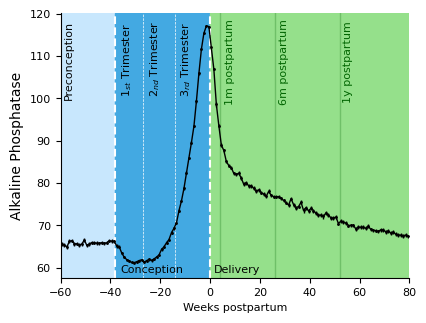

In [13]:
test    = 'PHOSPHATASE_ALKALINE'
stat    = 'value_at_quantile'

x,v,e,n = get_stats_from_dataset(test,stat)
ref     = get_age_matched_reference(test)

if stat == 'mean':
    ref_val = ref['mean']
    ylabel  = 'Mean value'
    ref_label = "Reference Population Mean"
    
if stat == 'value_at_quantile':
    ref_val   = ref['quantile'](0.5)
    ylabel    = 'Value at mean quantile'
    ref_label = "Reference Population Median"

plt.figure(figsize=(4.5,3.5))    
ax      = plt.subplot(111)
ax.errorbar(x,v,e,c='k',lw=1,fmt='-o',markersize=1,zorder=-3)
ax.set_xticks(np.arange(-60,100,20))
ax.set_xlabel('Weeks postpartum')
ax.set_ylabel(metadata.loc[test]['Nice name'],fontsize=10)# + ylabel)
# ax.set_title(metadata.loc[test]['Nice name'],fontsize=10)    
ax.set_xlim([-60,80])
ax.set_ylim(ax.get_ylim()[0]*0.99,ax.get_ylim()[1])
ax.axvspan(-60,-38,color='#C8E7FD',zorder=-5)
ax.axvspan(-38,0,color='#43A9E2',zorder=-5)
ax.axvspan(0,80,color='#95E08B',zorder=-5)
ax.axvline(x=4,c='darkgreen',ls='-',zorder=-3,lw=1,alpha=0.25)
ax.axvline(x=26,c='darkgreen',ls='-',zorder=-3,lw=1,alpha=0.25)
ax.axvline(x=52,c='darkgreen',ls='-',zorder=-3,lw=1,alpha=0.25)
ax.axvline(x=-27,c='white',ls='--',zorder=-4,lw=0.5)
ax.axvline(x=-14,c='white',ls='--',zorder=-4,lw=0.5)
ax.axvline(x=-38,c='white',ls='--',zorder=-4)
ax.axvline(x=0,c='white',ls='--',zorder=-4)
ax.annotate('1m postpartum',xy=(0.47,0.66),xycoords='axes fraction',rotation = 90,c='darkgreen',alpha=0.99)
ax.annotate('6m postpartum',xy=(0.625,0.66),xycoords='axes fraction',rotation = 90,c='darkgreen',alpha=0.99)
ax.annotate('1y postpartum',xy=(0.81,0.67),xycoords='axes fraction',rotation = 90,c='darkgreen',alpha=0.99)
ax.annotate('Preconception',xy=(0.01,0.68),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('$1_{st}$ Trimester',xy=(0.17,0.7),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('$2_{nd}$ Trimester',xy=(0.25,0.7),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('$3_{rd}$ Trimester',xy=(0.34,0.7),xycoords='axes fraction',rotation = 90,alpha=0.99)
ax.annotate('Conception',xy=(0.17,0.02),xycoords='axes fraction',alpha=0.99)
ax.annotate('Delivery',xy=(0.44,0.02),xycoords='axes fraction',alpha=0.99)
remove_top_right_frame([ax])
plt.savefig('test_intro.pdf',bbox_inches = 'tight',dpi=300); plt.show()

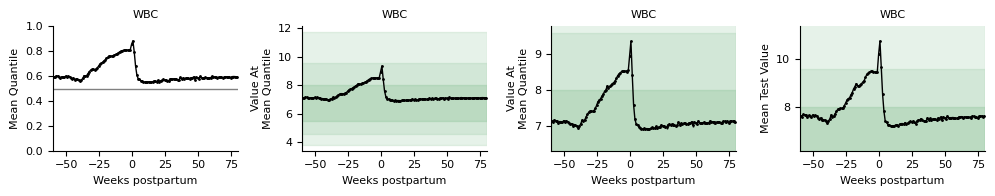

In [14]:
test =   'WBC'  
plt.figure(figsize=(10,2))    
ax1,ax2,ax3,ax4 = plt.subplot(141),plt.subplot(142),plt.subplot(143),plt.subplot(144)
plot_test(test,'quantile',ax1)                                
plot_test(test,'value_at_quantile',ax2)                       
plot_test(test,'value_at_quantile',ax3,focus_background=False)
plot_test(test,'mean',ax4,focus_background=False)
plt.tight_layout(); plt.show()

## Subplots of tests

In [15]:
def plot_tests_one_axe(ax,tests,title):
    qstd   = pd.DataFrame([data[test]['quantile']['value'].std() for test in tests],index = tests)
    tests_ = qstd.sort_values(by =0,ascending=False).index
    norm   = matplotlib.colors.Normalize(vmin=0, vmax=len(tests_)-1, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.turbo)
    for j,test in enumerate(tests_):
        x,v,e,n = get_stats_from_dataset(test,'quantile')
        offset = get_stats_from_dataset(test,'quantile')[1].iloc[:5].mean()
        v      = v - offset

        ax.plot(x,v,c=mapper.to_rgba(j),lw=0.5,zorder=-3,alpha=0.8-0.4*((len(tests_)-j)/len(tests_)))
        ax.fill_between(x,v+e,v-e,color=mapper.to_rgba(j),lw=1,zorder=-3,alpha=0.6-0.45*((len(tests_)-j)/len(tests_)))

        max_min = np.argmax([np.abs(0.5 - v.max()),np.abs(0.5-v.min())])
        xl      = np.array([v.idxmax(),v.idxmin()])[max_min]
        yl      = np.array([v.max(),v.min()])[max_min]
        txt     = ax.text(xl,yl,metadata.loc[test]['Nice name'],ha='center',fontsize=8,color=mapper.to_rgba(j),alpha=0.8-0.4*((len(tests_)-j)/len(tests_)))
    ax.set_yticks(np.arange(-0.5,0.75,0.25)); ax.set_ylabel('Percentile Change'); ax.set_ylim([-0.5,0.5])
    ax.set_xticks(np.arange(-60,100,20)) ; ax.set_xlabel('Weeks postpartum'); ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.1,zorder=-20)
#     ax.axvline(-28,c='dimgray',ls='--',alpha=0.25,lw=1,zorder=-20)
#     ax.axvline(-16,c='dimgray',ls='--',alpha=0.25,lw=1,zorder=-20)

    ax.set_facecolor('w')
    remove_top_right_frame([ax])
    ax.text(-54,0.425,title,fontsize=10,color='k')


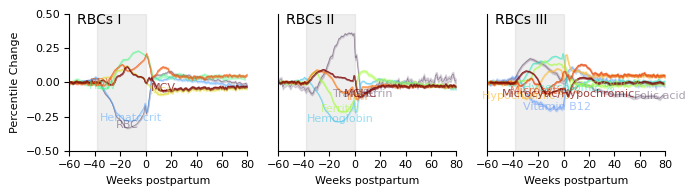

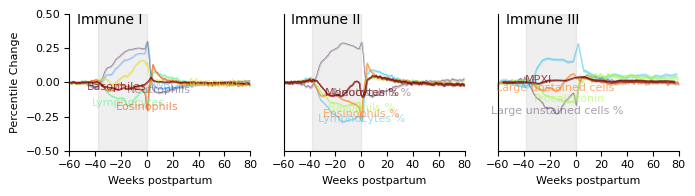

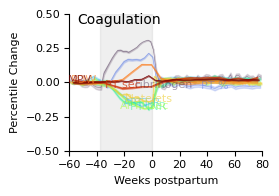

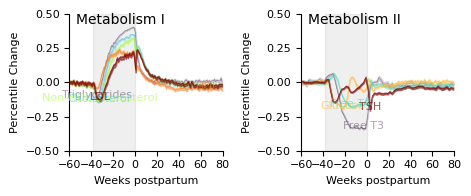

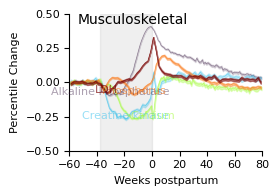

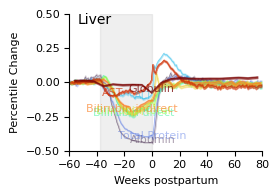

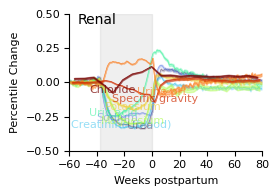

In [16]:
#### RBCs
plt.figure(figsize=(7,2))
ax1,ax2,ax3  = plt.subplot(1,3,1),plt.subplot(1,3,2),plt.subplot(1,3,3)
plot_tests_one_axe(ax1,['RBC', 'HCT','MCV','MCH','RDW','HDW'],'RBCs I')
plot_tests_one_axe(ax2,['FERRITIN','IRON','HGB','TRANSFERRIN','MCHC'],'RBCs II')
plot_tests_one_axe(ax3,['MICR_perc','MICROperc_HYPOperc','MACROperc','HYPERperc',
                        'HYPO_perc','VITAMIN_B12','FOLIC_ACID'],'RBCs III')
for ax in [ax2,ax3]:
    ax.set_ylabel('') 
    ax.set_yticklabels([])
    ax.set_yticks([]) 
plt.tight_layout(); plt.savefig('RBCs_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

#### Immune
plt.figure(figsize=(7,2))
ax1,ax2,ax3  = plt.subplot(1,3,1),plt.subplot(1,3,2),plt.subplot(1,3,3)
plot_tests_one_axe(ax1,['NEUT', 'WBC','EOS','MONO','LYMP','BASOPHILES_abs'],'Immune I')
plot_tests_one_axe(ax2,['NEUTperc','EOS_perc','MONperc','LYMperc','BASO_perc'],'Immune II')
plot_tests_one_axe(ax3,['C_REACTIVE_PROTEIN_CRP','LUC','LUCperc','PCT','MPXI'],'Immune III')
for ax in [ax2,ax3]:
    ax.set_ylabel('') 
    ax.set_yticklabels([])
    ax.set_yticks([])   
plt.tight_layout(); plt.savefig('Immune_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

#### Coagulation
plt.figure(figsize=(7,2))
ax1   = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['FIBRINOGEN', 'APTT_R','APTT_sec','PT_INR',
                        'PT_SEC','PT_perc','PDW','MPV','PLT'],'Coagulation')
plt.tight_layout(); plt.savefig('Coagulation_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

#### Metabolism
plt.figure(figsize=(7,2))
ax1,ax2  = plt.subplot(1,3,1),plt.subplot(1,3,2)
plot_tests_one_axe(ax1,['TRIGLYCERIDES', 'CHOLESTEROL','CHOLESTEROL_HDL',
                        'CHOLESTEROL_LDL','NON_HDL_CHOLESTEROL'],'Metabolism I')
plot_tests_one_axe(ax2,['GLUCOSE_BLOOD','T4_FREE','T3_FREE','TSH_THYROID_STIMULATING_HORMONE'],'Metabolism II ')

plt.tight_layout(); plt.savefig('Metabolism_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

#### Musculoskeletal
plt.figure(figsize=(7,2))
ax1 = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['PHOSPHATASE_ALKALINE', 'LACTIC_DEHYDROGENASE_LDH__BLOOD','PHOSPHORUS_BLOOD',
                        'CALCIUM_BLOOD','CK_CREAT'],'Musculoskeletal')
plt.tight_layout(); plt.savefig('Musculoskeletal_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

#### Liver
plt.figure(figsize=(7,2))
ax1  = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['PROTEIN_TOTAL_BLOOD', 'ALBUMIN','GLOBULIN','ALT_Alanine_aminotransferase_GPT',
                        'AST_Aspartate_aminotransferase_GOT','GAMMA_GLUTAMYL_TRANSPEPTIDASE',
                       'BILIRUBIN_DIRECT','BILIRUBIN_INDIRECT','BILIRUBIN_TOTAL'],'Liver')
plt.tight_layout(); plt.savefig('Liver_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

#### Kidney 
plt.figure(figsize=(7,2))
ax1  = plt.subplot(1,3,1)
plot_tests_one_axe(ax1,['CREATININE_BLOOD', 'UREA_BLOOD','URIC_ACID_BLOOD',
                        'Na','K','Cl','MAGNESIUM_BLOOD','PH_u','SPECIFIC_GRAVITY'],'Renal')
plt.tight_layout(); plt.savefig('Kidney_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()

In [17]:
def plot_qunatile_change(ax,test):
    qstd   = pd.DataFrame([data[test]['value_at_quantile']['value'].std() for test in tests],index = tests)


    x,v,e,n = get_stats_from_dataset(test,'value_at_quantile')
    
#     offset = get_stats_from_dataset(test,'value_at_quantile')[1].iloc[:5].mean()
#     v      = v - offset
    ylim_   = np.max(v) + (np.max(v)-np.min(v))*0.2
    ylim_1  = np.min(v) - (np.max(v)-np.min(v))*0.2
    
    ax.errorbar(x,v,e,c='k',lw=1)
    # ax.set_ylabel('Percentile\nChange',fontsize=6); 

    ax.set_ylim([ylim_1,ylim_])
    ax.set_xticks(np.arange(-50,100,50)) ; ax.set_xlabel('Weeks\npostpartum',fontsize=6); ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.1,zorder=-20)

    ax.set_facecolor('w')
    remove_top_right_frame([ax])
    ax.annotate(metadata.loc[test]['Short name'],(0.05,1.05),xycoords='axes fraction',fontsize=8,color='k')
    ax.tick_params(axis='both', which='major', labelsize=6)
    

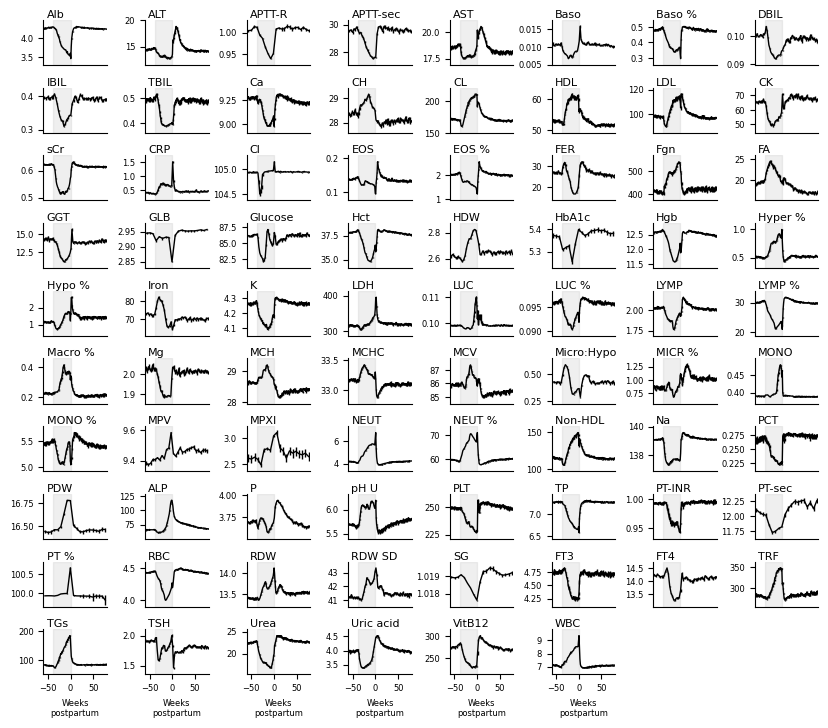

In [18]:
plt.figure(figsize=(10,np.ceil(len(tests))/9))
for i,test in enumerate(tests):
    ax    = plt.subplot(int(np.ceil(len(tests)/8)),8,i+1)
    plot_qunatile_change(ax,test)
    
    if i<len(tests)-6:
        ax.set_xticks([])
        ax.set_xlabel('')
    if np.mod(i,8) != 0:
        ax.set_ylabel('')
#         ax.set_yticks([])
    
plt.subplots_adjust(hspace=0.5,wspace=0.6);
plt.savefig('Atlas_AZ_overview.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);
plt.show()    

# SI - all tests

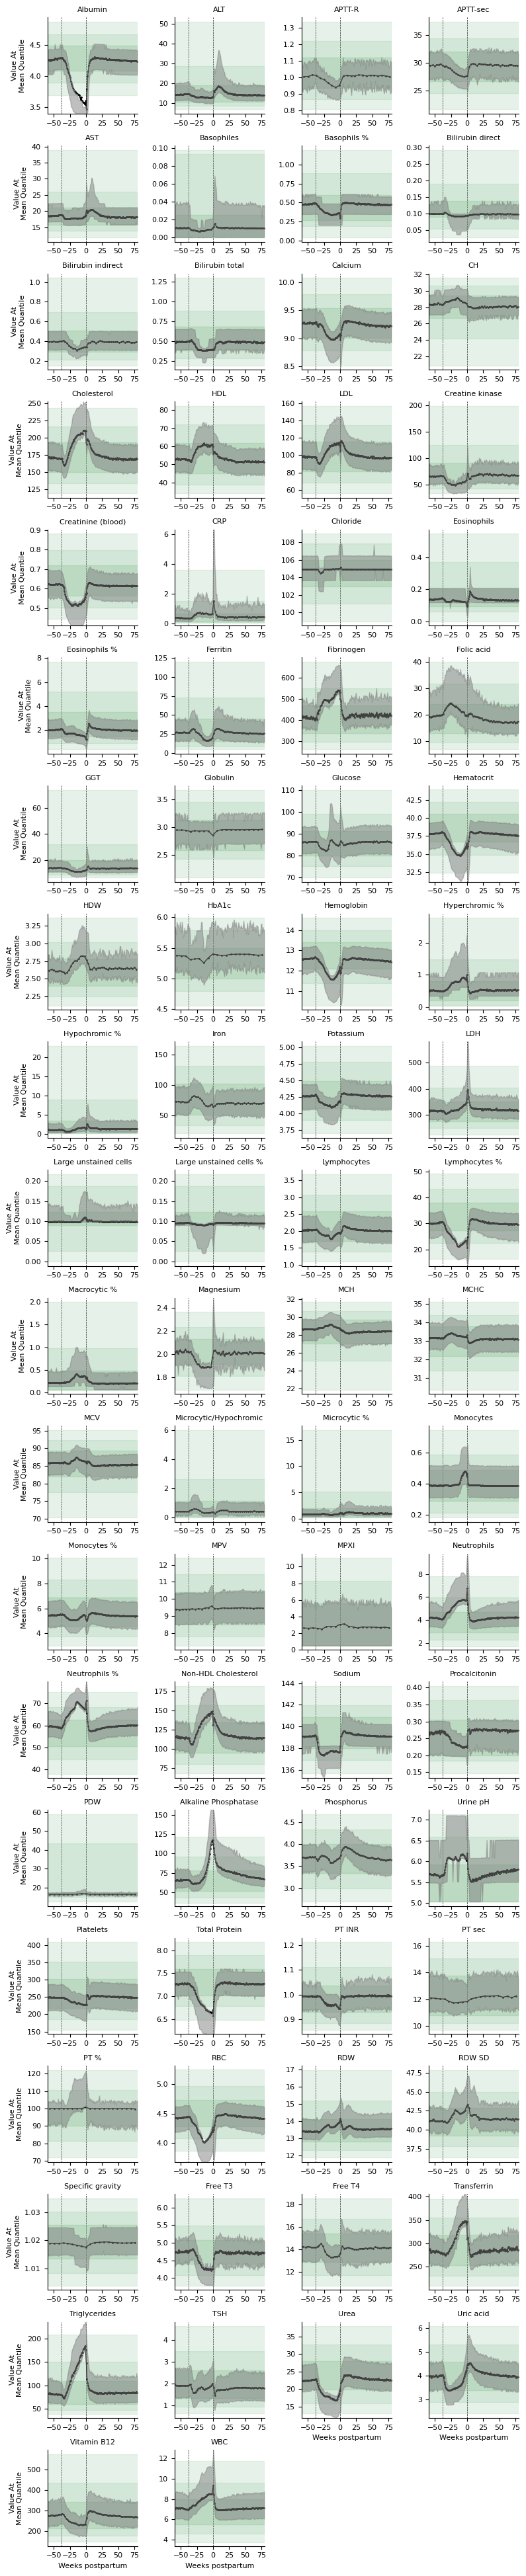

In [19]:
plt.figure(figsize=(8,np.ceil(len(tests))/2))
for i,test in enumerate(tests):
    ax  = plt.subplot(int(np.ceil(len(tests)/4)),4,i+1)

    if test in labnorm_tests:
        plot_test(test,'value_at_quantile',ax)

        ref = get_age_matched_reference(test)
        p25 = ref['quantile'](dfs[test]['qq25'])
        p75 = ref['quantile'](dfs[test]['qq75'])
        ax.fill_between(x,p25,p75,color='gray',alpha=0.5)
        
    else:
        plot_test(test,'mean',ax,c='gray')
        p25 = dfs[test]['q25']
        p75 = dfs[test]['q75']
        ax.fill_between(x,p25,p75,color='gray',alpha=0.5)
    
    ax.axvline(-38,0,c='k',ls='--',lw=0.5,zorder=-20)
    ax.axvline(0,0,c='k',ls='--',lw=0.5,zorder=-20)


    ylm = np.array(ax.get_ylim())

    if np.min(p25) < ylm[0]:
        ylm[0] = np.min(p25)

    if np.max(p75) > ylm[1]:
        ylm[1] = np.max(p75)
    ax.set_ylim(ylm)

    if i<len(tests)-4:
        ax.set_xlabel('')
    if np.mod(i,4) != 0:
        ax.set_ylabel('')  
        
plt.tight_layout();
plt.savefig('subplots_full_si.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

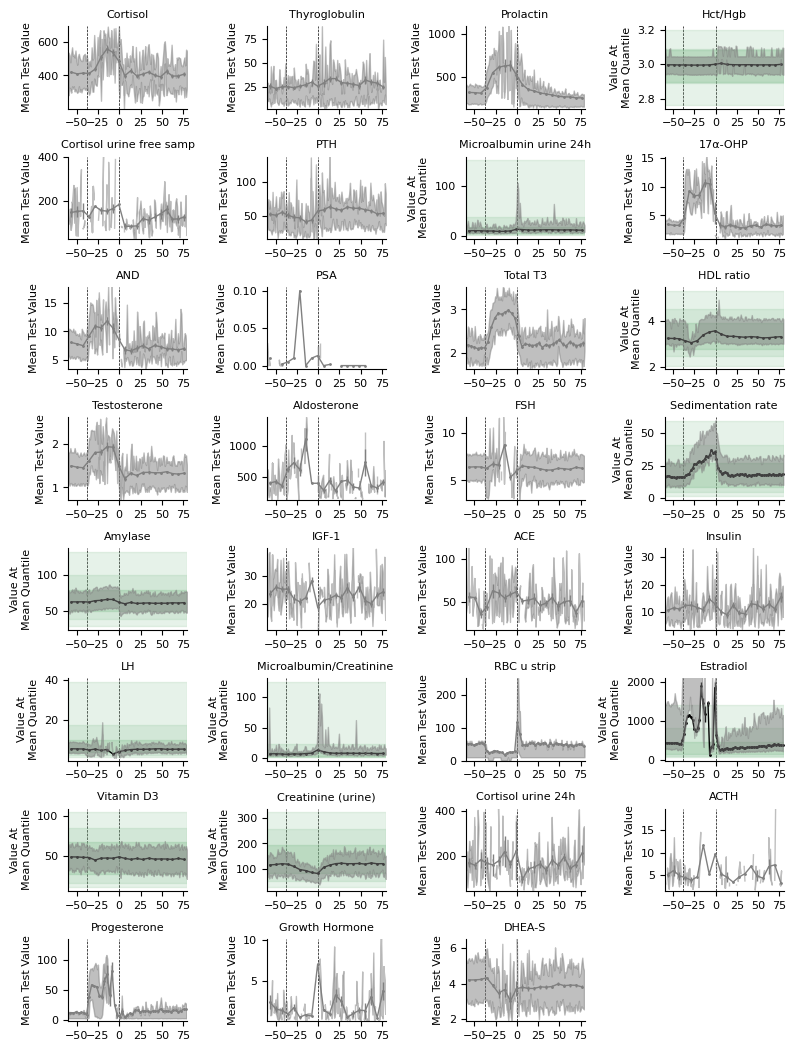

In [20]:
### Plot tests not in analysis
plt.figure(figsize=(8,np.ceil(len(tests))/3))
for i,test in enumerate(removed_tests):
    ax  = plt.subplot(int(np.ceil(len(tests)/4)),4,i+1)
    
    if test in list(set(labnorm_tests) - set(['PSA_PROSTATIC_SPECIFIC_ANTIGEN'])):
        plot_test(test,'value_at_quantile',ax)
        ref = get_age_matched_reference(test)
        p25 = ref['quantile'](dfs[test]['qq25'])
        p75 = ref['quantile'](dfs[test]['qq75'])
        ax.fill_between(x,p25,p75,color='gray',alpha=0.5)
    else:
        plot_test(test,'mean',ax,c='gray')
        p25 = dfs[test]['q25']
        p75 = dfs[test]['q75']
        ax.fill_between(x,p25,p75,color='gray',alpha=0.5)

    ylm = np.array(ax.get_ylim())
    ax.axvline(-38,0,c='k',ls='--',lw=0.5,zorder=-20)
    ax.axvline(0,0,c='k',ls='--',lw=0.5,zorder=-20)

    if np.min(p25) < ylm[0]:
        ylm[0] = np.min(p25)

    if np.max(p75) > ylm[1]:
        ylm[1] = np.max(p75)
        ax.set_ylim(ylm)
        
    if i<len(tests)-5:
        ax.set_xlabel('')

plt.tight_layout();
plt.savefig('subplots_not_in_analysis.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

In [21]:
cols = ['n', 'Mean', 'Median', 'SD', 
         'Age (mean)', 'Age (25th percentile)', 'Age (25th percentile)',
         'BMI (mean)', 'BMI (25th percentile)', 'BMI (25th percentile)',
         'raw (25th percentile)','raw (75th percentile)',
         'Quantile (mean)','Quantile (median)','Quantile (25th percentile)','Quantile (75th percentile)',
         'Value at Quantile (mean)','Value at Quantile (SEM)','Value at Quantile (25th percentile)','Value at Quantile (75th percentile)']

with pd.ExcelWriter('SI_atlas_mini.xlsx') as writer:  
    for test in tests:
        
        temp = data[test]['value_at_quantile'].copy()
        ref  = get_age_matched_reference(test)
        p25  = ref['quantile'](dfs[test]['qq25'])
        p75  = ref['quantile'](dfs[test]['qq75'])
        temp['q25'] = p25
        temp['q75'] = p75
        tdf = pd.concat((dfs[test],temp.drop(columns=['n'])),axis=1)
        tdf.columns = cols
        tdf.to_excel(writer,sheet_name=metadata.loc[test]['Nice name'].replace(':', '').replace('/', ''))  